In [2]:
import pandas as pd
import numpy as np
import pdb 
from datetime import datetime, timedelta
from dis import dis
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

data = pd.read_csv("prepped_data.csv")

In [4]:
#Temporal tunning analysis (Fig.2) of Manassi et al.(2019): https://whitneylab.berkeley.edu/PDFs/Manassi_Scientific_Reports.pdf

#Fig2A
#correct answers
correct = data['score']==100
correct[data['chosen_answer']=="['nevus']"].value_counts()[True] #326920
correct[data['chosen_answer']=="['melanoma']"].value_counts()[True] #287219

#### similar / dissimilar
pos_sim = data['similarity_to_previous'].abs()
treshold = pos_sim.mean()

is_similar = []

for i in pos_sim:
    sim = i<treshold
    
    is_similar.append(int(sim))

data['is_similar'] = is_similar
#data = data[data['is_similar']==1] #for similar = 1, for dissimilar = 0

#incorrect answers
incorrect = data['score']==0
incorrect[data['chosen_answer']=="['nevus']"].value_counts()[True] #64882
incorrect[data['chosen_answer']=="['melanoma']"].value_counts()[True] #76980

#Fig2B
M_incorrect = incorrect[data['chosen_answer']=="['melanoma']"]
B_incorrect = incorrect[data['chosen_answer']=="['nevus']"]

#Fig2B.B
BBM = M_incorrect[data['current_correct_answer'].shift(periods = 1) == "['nevus']"].value_counts()[True] #44248 #false positive
BMB = B_incorrect[data['current_correct_answer'].shift(periods = 1) == "['nevus']"].value_counts()[True] #37877 #false negative

#Fig2B.M
MBM = M_incorrect[data['current_correct_answer'].shift(periods = 1) == "['melanoma']"].value_counts()[True] #32732
MMB = B_incorrect[data['current_correct_answer'].shift(periods = 1) == "['melanoma']"].value_counts()[True] #27005

#Fig2C
# Serial Dependence when correct answer is malignant (Diagnostic Error!):
BMB / (BMB + MMB) #58.4% -> 8.4% Serial Dependence towards 1-back if previous image is benign

# Serial Dependence when correct answer is benign :
MBM / (MBM + BBM) #42.5% -> no one-back if previous image is malignant

(BMB + MBM) / (BMB + MMB + MBM + BBM) #no SD over all incorrect answers

# maybe error was less if previous was malignant -> base rate: "It already has been malignant last time, no way it's malignant AGAIN!"

0.4977301884930425

In [22]:
#Errors across categories
#45% Error when correct answer is malignant:
B_incorrect.value_counts()[True] / (B_incorrect.value_counts()[True] + M_incorrect.value_counts()[True]) 
#54% Error when correct answer is benign:
M_incorrect.value_counts()[True] / (M_incorrect.value_counts()[True] + B_incorrect.value_counts()[True])

0.6128870422064139

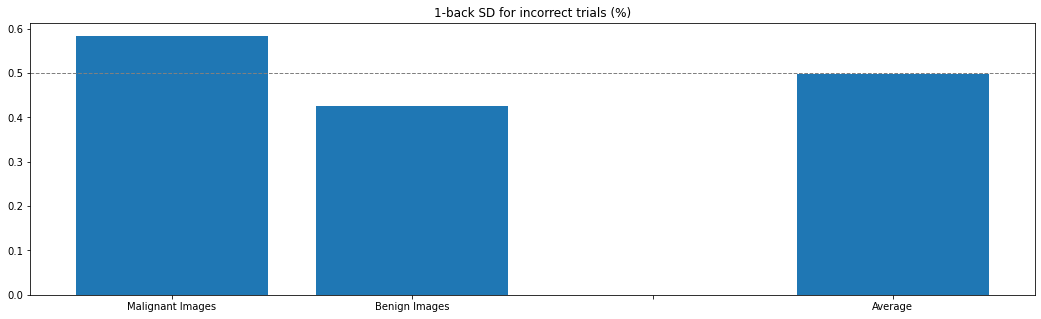

In [5]:
# PLOT 1 
height = [BMB / (BMB + MMB), MBM / (MBM + BBM), 0, (BMB + MBM) / (BMB + MMB + MBM + BBM)]
bars = ('Malignant Images', 'Benign Images', ' ', 'Average')
x_pos = np.arange(len(bars))

plt.figure(figsize=(18, 5))
plt.bar(x_pos, height)
plt.title('1-back SD for incorrect trials (%)')
plt.axhline(y=0.5,linewidth=1, color='grey', linestyle='--') 
plt.xticks(x_pos, bars)

plt.show()

#8.4% (58.4%) SD towards 1-back if previous image is benign, negative SD when previous image is malignant

In [5]:
#Problem: there are more trials when previous was benign than malignant

data['current_correct_answer'].value_counts(1)

['nevus']       0.57263
['melanoma']    0.42737
Name: current_correct_answer, dtype: float64

In [6]:
data['chosen_answer'].value_counts(1)

['nevus']       0.518256
['melanoma']    0.481744
Name: chosen_answer, dtype: float64

In [6]:
# Take similarity (S) and dissimilarity (D) into account

# MALIGNANT

BBMS = data[(data.score==0) & (data.chosen_answer == "['melanoma']")& (data.current_correct_answer.shift(1) == "['nevus']") & (data.is_similar == 1)].shape[0]

MBMS = data[(data.score==0) & (data.chosen_answer == "['melanoma']")& (data.current_correct_answer.shift(1) == "['melanoma']") & (data.is_similar == 1)].shape[0]

BBMD = data[(data.score==0) & (data.chosen_answer == "['melanoma']")& (data.current_correct_answer.shift(1) == "['nevus']") & (data.is_similar == 0)].shape[0]

MBMD = data[(data.score==0) & (data.chosen_answer == "['melanoma']")& (data.current_correct_answer.shift(1) == "['melanoma']") & (data.is_similar == 0)].shape[0]

# BENIGN

BMBS = data[(data.score==0) & (data.chosen_answer == "['nevus']")& (data.current_correct_answer.shift(1) == "['nevus']") & (data.is_similar == 1)].shape[0]

MMBS = data[(data.score==0) & (data.chosen_answer == "['nevus']")& (data.current_correct_answer.shift(1) == "['melanoma']") & (data.is_similar == 1)].shape[0]

BMBD = data[(data.score==0) & (data.chosen_answer == "['nevus']")& (data.current_correct_answer.shift(1) == "['nevus']") & (data.is_similar == 0)].shape[0]

MMBD = data[(data.score==0) & (data.chosen_answer == "['nevus']")& (data.current_correct_answer.shift(1) == "['melanoma']") & (data.is_similar == 0)].shape[0]

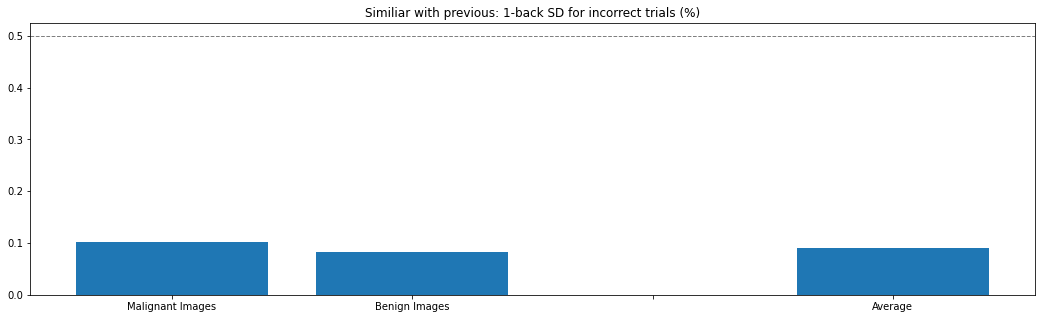

In [7]:
# PLOT 2: Similar with previous 

height = [BMBS / (BMBS + MMBS), MBMS / (MBMS + BBMS), 0, (BMBS + MBMS) / (BMBS + MMBS + MBMS + BBMS)]
bars = ('Malignant Images', 'Benign Images', ' ', 'Average')
x_pos = np.arange(len(bars))

plt.figure(figsize=(18, 5))
plt.bar(x_pos, height)
plt.title('Similiar with previous: 1-back SD for incorrect trials (%)')
plt.axhline(y=0.5,linewidth=1, color='grey', linestyle='--') 
plt.xticks(x_pos, bars)

plt.show()

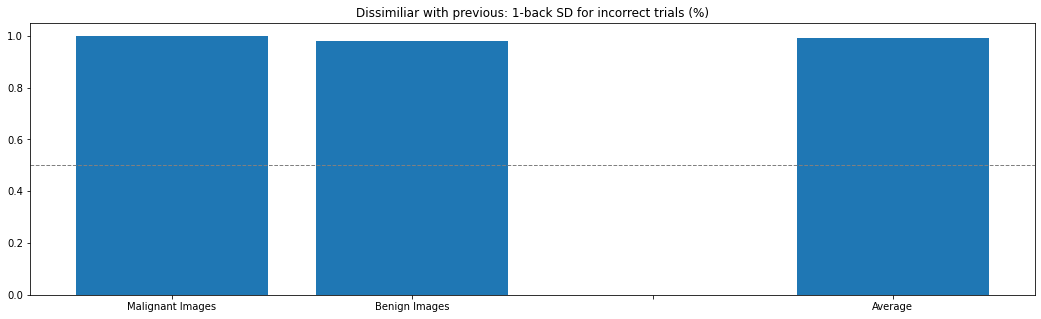

In [8]:
# PLOT 3: Dissimilar with previous 

height = [BMBD / (BMBD + MMBD), MBMD / (MBMD + BBMD), 0, (BMBD + MBMD) / (BMBD + MMBD + MBMD + BBMD)]
bars = ('Malignant Images', 'Benign Images', ' ', 'Average')
x_pos = np.arange(len(bars))

plt.figure(figsize=(18, 5))
plt.bar(x_pos, height)
plt.title('Dissimiliar with previous: 1-back SD for incorrect trials (%)')
plt.axhline(y=0.5,linewidth=1, color='grey', linestyle='--') 
plt.xticks(x_pos, bars)

plt.show()